# Analysing sales commission with atoti
\[_In case you’re unable to see the atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/notebooks/blob/master/notebooks/sales-commission/main.ipynb)._]

In the previous use case, we looked at [Sales cube in atoti](../sales_cube/main.ipynb) and saw how we can draw meaningful insights from sales transactions.  
In this notebook, we take a different perspective into the car sales industry and evaluate the commissions that salespeople draw from the sales of cars.  

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=sales-commission" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="atoti table" /></a></div>

## 1 Understanding the datasets
This notebooks refactored and extended the dataset used by the notebook for [Sales cube in atoti](../sales_cube/main.ipynb) to include data on:
- Showrooms where the transactions occurred
- Salespeople who made the transactions
- Cars pricing for each showroom
- [Spiffs](https://en.wikipedia.org/wiki/Spiff#:~:text=A%20spiff%2C%20or%20spiv%2C%20is,for%20selling%20a%20specific%20product.) on car models during specific timing  

Do note that we are using synthetic data here for demonstrative purpose only. It does not reflect the true earning of car salespeople ◕‿◕

## 2 Loading up atoti tables

In [1]:
import pandas as pd

import atoti as tt

In [2]:
session = tt.Session(user_content_storage= "./content")

### 2.1 Sales invoice data

We computed the age of the salesperson at the point of sales to draw some insights on the car sales from age groups.

In [3]:
car_sales = session.read_csv(
    "s3://data.atoti.io/notebooks/sales-commission/sales_invoices.csv",
    table_name="Car Sales",
    keys=["sales_invoice"],
    types={
        "customer_id": tt.type.STRING,
        "year": tt.type.STRING,
        "month": tt.type.STRING,
        "day": tt.type.STRING,
        "age of salesperson": tt.type.STRING,
    },
)

car_sales.head()

,date_of_purchase,model_id,color,customer_id,salesperson_id,showroom_code,year,month,day,age of salesperson
sales_invoice,,,,,,,,,,
20180101/00001,2018-01-01,CM0000,Teal,67255399,SR34SP_0036,SR34,2018,1,1,50
20190618/00442,2019-06-18,CM0941,Teal,20692650,SR25SP_0066,SR25,2019,6,18,45
20190623/01021,2019-06-23,CM2311,Teal,54565678,SR25SP_0066,SR25,2019,6,23,45
20190430/00711,2019-04-30,CM1536,Aqua,28131199,SR22SP_0044,SR22,2019,4,30,25
20180103/00711,2018-01-03,CM1399,Teal,80832591,SR34SP_0036,SR34,2018,1,3,50


### 2.2 Cars pricing by showrooms

Different showrooms have have different selling price and different amount of [dealer holdback](https://www.autocheatsheet.com/new-car/dealer-holdback.html) for different car models.  
Prices may fluctuate across different periods in time due to seasonal promotions etc. For simplicity, we kept the price constant for each month.  

Instead of loading the CSV directly into atoti table, we load it into a Pandas DataFrame to do some pre-processing computation.

In [4]:
pricelist = pd.read_csv(
    "https://data.atoti.io/notebooks/sales-commission/showroom_pricelist.csv"
)
pricelist.head()

,year,month,showroom_code,model_id,price,cost_price,dealer_holdback
0,2018,1,SR00,CM0877,155700.0,153066.0,0.0
1,2018,2,SR00,CM0877,155700.0,153066.0,0.0
2,2018,3,SR00,CM0877,155700.0,153066.0,0.0
3,2018,4,SR00,CM0877,155700.0,153066.0,0.0
4,2018,5,SR00,CM0877,155700.0,153066.0,0.0


[atoti](https://atoti.io/) inherits the data type for the columns from Pandas. As such, let's cast the `year` and `month` columns as strings.

In [5]:
pricelist[["year", "month"]] = pricelist[["year", "month"]].astype(str)

#### 2.2.1 Pre-processing: computing profit before loading into cube

Dealer holdback is given from the car manufacturers to the car dealers for selling the car. But not all manufacturers participate in dealer holdbacks.  
In our use case, only Mercedes has dealer holdbacks of 1%, while Audi and BMW do not have.  

In our data, `cost_price` is inclusive of the `dealer_holdback`. Dealer holdback are not included in the `gross profit` that is used to compute the commissions of salespeople.

In [6]:
pricelist["profit"] = pricelist["price"] - pricelist["cost_price"]

pricelist["gross profit"] = (
    pricelist["price"] - pricelist["cost_price"] - pricelist["dealer_holdback"]
)

Deriving the profit before loading data into the cube is also known as pre-processing. Since this value will not change with respect to different dimensions, we can safely compute it in advance to save computation effort in the cube. Read the article [Why do we need multidimensional analysis?](https://www.atoti.io/why-do-we-need-multidimensional-analysis/) to understand more about pre-processing.  

Perform a quick check on the data types for each column before loading them into an atoti table.

In [7]:
pricelist.dtypes

year                object
month               object
showroom_code       object
model_id            object
price              float64
cost_price         float64
dealer_holdback    float64
profit             float64
gross profit       float64
dtype: object

In [8]:
car_pricing = session.read_pandas(
    pricelist,
    table_name="Car Prices",
    keys=["year", "month", "showroom_code", "model_id"],
)
car_pricing.head()

,,,,price,cost_price,dealer_holdback,profit,gross profit
month,year,showroom_code,model_id,,,,,
1,2018,SR00,CM0877,155700.0,153066.0,0.0,2634.0,2634.0
2,2018,SR00,CM0877,155700.0,153066.0,0.0,2634.0,2634.0
3,2018,SR00,CM0877,155700.0,153066.0,0.0,2634.0,2634.0
4,2018,SR00,CM0877,155700.0,153066.0,0.0,2634.0,2634.0
5,2018,SR00,CM0877,155700.0,153066.0,0.0,2634.0,2634.0


### 2.3 Spiffs  

Spiff is a short-term sales incentive strategy and in our use case, we assigned spiffs of varying amount to random car models for a period of time as incentive to simply boost sales for certain car models or cars that have been in lot for too long.

In [9]:
spiffs = session.read_csv(
    "s3://data.atoti.io/notebooks/sales-commission/spiffs.csv",
    table_name="Spiffs",
    keys=["showroom_code", "year", "month", "model_id"],
    types={
        "year": tt.type.STRING,
        "month": tt.type.STRING,
    },
)
spiffs.head()

,,,,spiff_amount
month,year,showroom_code,model_id,
8,2019,SR48,CM0863,50
9,2019,SR48,CM0863,50
10,2019,SR48,CM0863,50
11,2019,SR48,CM0863,50
12,2019,SR48,CM0863,50


### 2.4 Car models

In [10]:
car_model = session.read_csv(
    "s3://data.atoti.io/notebooks/sales-commission/car_models.csv",
    table_name="Car Models",
    keys=["model_id"],
)
car_model.head()

,brand,model,body-type,transmission,fuel
model_id,,,,,
CM0000,Audi,A3,Cabriolet,Automatic,Diesel
CM0001,Audi,A3,Cabriolet,Automatic,Gasoline
CM0002,Audi,A3,Cabriolet,Automatic,Hybrid
CM0003,Audi,A3,Cabriolet,CVT,Diesel
CM0004,Audi,A3,Cabriolet,CVT,Gasoline


### 2.5 Salespeople

In [11]:
salesperson = session.read_csv(
    "s3://data.atoti.io/notebooks/sales-commission/salesperson.csv",
    table_name="Salesperson",
    keys=["showroom_code", "salesperson_id"],
)
salesperson.head()

,,surname,given_name,gender,dob
salesperson_id,showroom_code,,,,
SR00SP_0000,SR00,Garcia,Roy,M,1977-07-31
SR00SP_0001,SR00,Anderson,Andrew,M,1986-02-28
SR00SP_0002,SR00,Johnson,Willie,M,1994-05-30
SR00SP_0003,SR00,Peterson,Steven,M,1995-11-19
SR00SP_0004,SR00,Hogan,Matthew,M,1974-10-22


### 2.6 Age group

We create bucketing with Pandas DataFrame.

In [12]:
# age group buckets
age_groups = session.read_pandas(
    pd.DataFrame(
        data=[("<=24Y", str(i)) for i in range(15, 25)]
        + [("25Y - 34Y", str(i)) for i in range(25, 35)]
        + [("35Y - 49Y", str(i)) for i in range(35, 50)]
        + [("50+", str(i)) for i in range(50, 60)],
        columns=["age_group", "age"],
    ),
    keys=["age"],
    table_name="age_groups",
    types={
        "age": tt.type.STRING,
    },
)

### 2.7 Showrooms

In [13]:
showroom = session.read_csv(
    "s3://data.atoti.io/notebooks/sales-commission/showrooms.csv",
    table_name="Showrooms",
    keys=["showroom_code"],
)

showroom.head()

,state,latitude,longitude
showroom_code,,,
SR00,Alabama,30.658284,-88.124338
SR01,Alabama,32.561008,-85.504021
SR02,Alabama,34.421421,-85.740996
SR03,Arizona,32.278850,-110.985918
SR04,Arizona,33.324838,-111.841054


## 3 Joining tables

In [14]:
car_sales.join(car_pricing)
car_pricing.join(car_model)
car_pricing.join(spiffs)

car_sales.join(salesperson)
car_sales.join(age_groups, mapping={"age of salesperson": "age"})
car_sales.join(showroom)

## 4 Creating multidimensional data cube with atoti

Since the `Car Sales` table contains the most granular level data, we will use it as our base table to create the atoti cube.

In [15]:
cube = session.create_cube(car_sales, "Sales commission")

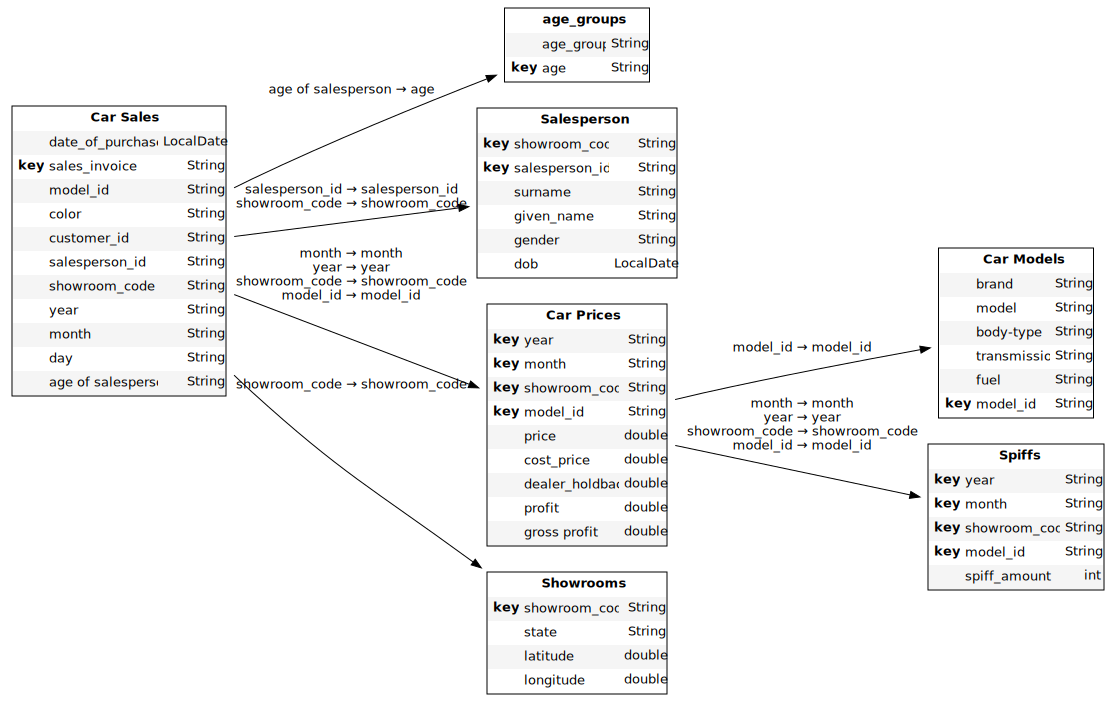

In [16]:
cube.schema

## 5 Manipulating the cube

We can manipulate the cube via its properties - `hierarchies`, `levels` and `measures`.  
It is more convenient to aliase and use these properties.

In [17]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

### 5.1 Creating date hierarchy from an existing column

We can create multilevel date hierarchy from the existing `date_of_purchase` column to get insights at Yearly, Quarterly or Monthly level.

In [18]:
cube.create_date_hierarchy(
    "Date",
    column=car_sales["date_of_purchase"],
    levels={"Year": "yyyy", "Quarter": "QQQ", "Month": "MM"},
)

Since we will be evaluating the performance of the salespeople, we can extend the date hierarchy to include the `salesperson_id`.

In [19]:
h["Date"] = {**h["Date"].levels, "Salesperson_id": car_sales["salesperson_id"]}

This allows users to drill-down the pivot table and see the number of cars sold at each level in the hierarchy.

In [20]:
session.visualize("Number of cars sold by salesperson on monthly basis")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### 5.2 Setting order of levels

In some cases such as below, we are unable to sort the order by ascending nor descending order.

In [21]:
session.visualize("Age groups of salespeople")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

We use [comparators](https://docs.atoti.io/latest/lib/atoti.comparator.html#atoti.comparator.Comparator) to specify the sorting of levels.  
Below, we make use of `first_members` to arrange the age group in a specific order.

In [22]:
l["age_group"].order = tt.CustomOrder(first_elements=[
    "<=24Y", "25Y - 34Y", "35Y - 49Y", "50+"
])

In [23]:
session.visualize("Ordered by age groups of salespeople")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### 5.2 Creating measures 

Measures are the numerical properties of the datacube where we perform aggregation on and there are different types of [aggregation functions in atoti](https://docs.atoti.io/latest/lib/atoti.agg.html#module-atoti.agg).  
Let's see how we can create measures in atoti. 

#### 5.2.1 Creating measures from referenced tables

atoti automatically creates measures for numerical columns from the base table. We only have numerical values in the referenced table in this particular use case.  
Therefore, let's create our measures manually by aggregating the table columns.  

In [24]:
# aggregation on the table column
m["Car price"] = tt.agg.sum(car_pricing["price"])
m["Cost price"] = tt.agg.sum(car_pricing["cost_price"])
m["Dealer holdback"] = tt.agg.sum(car_pricing["dealer_holdback"])
m["Profit"] = tt.agg.sum(car_pricing["profit"])
m["Gross profit"] = tt.agg.sum(car_pricing["gross profit"])

# spiff is applicable up to salesperson_id level
m["Spiff"] = tt.where(l["Salesperson_id"] != None, tt.agg.sum(spiffs["spiff_amount"]))

# longitude and latitude are unique values for each showroom. Therefore, we can use `atoti.value` on the table column.
m["latitude"] = tt.value(showroom["latitude"])
m["longitude"] = tt.value(showroom["longitude"])

Now we can roll-up or drill-down the various business metrics. 

In [25]:
session.visualize("Profit breakdown")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 5.2.2 Creating cumulative measures  

We perform cumulative aggregation by using the [cumulative scope](https://docs.atoti.io/latest/lib/atoti.scope.html#atoti.scope.cumulative).  

`contributors.COUNT` is the number of contributing records, in this case, it represents the number of cars sold.  
We use [`atoti.agg.sum`](https://docs.atoti.io/latest/lib/atoti.agg.html#atoti.agg.sum) on the `contributors.COUNT` with the cumulative scope along the `date_of_purchase` to get the cumulative summation of sales quantity.  
We could also use [`atoti.agg.mean`](https://docs.atoti.io/latest/lib/atoti.agg.html#atoti.agg.mean) to get the cumulative average. 

In [26]:
m["Cumulative daily sales qty"] = tt.agg.sum(
    m["contributors.COUNT"], scope=tt.scope.cumulative(l["date_of_purchase"])
)

Below we accumulate the `Gross Profit` along the level `date_of_purchase`.

In [27]:
m["Cumulative gross profit"] = tt.agg.sum(
    m["Gross profit"],
    scope=tt.scope.cumulative(l["date_of_purchase"]),
)

##### 5.2.2.1 Breaking down metrics visually

Once we get the business metric `Cumulative daily sales qty`, we can easily visualize the sales trend across all the dealers.  
We can split the measure by different hierarchies to get the trend breakdown from different perspectives. In the below use case, we see the cumulative sales quantity by state.

In [28]:
session.visualize("Cumulative sales quantity on monthly basis")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 5.2.3 Conditional measures

In our use case, the percentage of commissions against the gross profit are computed based on the number of cars sold in the month by individual salesperson:
- 7 or less cars: 25%
- 8 - 10 cars: 30%
- 11 - 14 cars: 35%
- 15 or more cars: 40%  

We can derive the commission by using the [`atoti.where`](https://docs.atoti.io/latest/lib/atoti.html#atoti.where) function to apply the conditions.

In [29]:
m["Commission rate"] = tt.where(
    l["Salesperson_id"] != None,
    tt.where(
        m["Cumulative daily sales qty"] <= 7,
        0.25,
        tt.where(
            m["Cumulative daily sales qty"] <= 10,
            0.3,
            tt.where(m["Cumulative daily sales qty"] <= 14, 0.35, 0.4),
        ),
    ),
)

By using `Cumulative daily sales qty` to compute the `commission rate`, we can see that the applicable commission rate changed as the number of cars sold crossed the next hier threshold. This is useful when we want to know the effective commission rate in time. However, the final commission rate depends on the number of cars sold by the end of the month - value at the `Salesperson_id` level. 

Note that commission rate has no meaning above the `Salesperson_id` level, i.e. Month, Quarter, Year, since it is based on individual sales. Therefore, we have hidden its value with the condition `l["Salesperson_id"] != None`.

In [30]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Alternatively, we can compute the number of cars sold in the whole month at the query time by using the [`atoti.scope.siblings`](https://docs.atoti.io/latest/lib/atoti.scope.html#atoti.scope.siblings) - we sum up the `contributors.COUNT` across the `date_of_purchase` under each `Salesperson_id` within each `Month`.  

In [31]:
m["_total_sales_qty"] = tt.agg.sum(
    m["contributors.COUNT"], scope=tt.scope.siblings(h["date_of_purchase"])
)

m["Total sales qty"] = tt.total(
    m["_total_sales_qty"],
    h["date_of_purchase"],
    h["brand"],
    h["model"],
    h["body-type"],
    h["color"],
    h["sales_invoice"],
)

Using [`atoti.total`](https://docs.atoti.io/latest/lib/atoti.html#atoti.total) function, we can get the value of the top level member of the listed hierarchies. We do so in order to cascade the total sales quantity from the `date_of_purchase` level to the lower levels - this allows us to drill-down and see the properties of the car sold and its equivalent commission. Without the `atoti.total`, the quantity will be broken down to the most granular level.  

<img src="./atoti_total.png" alt="Cascade top level value" width="80%" style="display:block;margin-left: auto;margin-right: auto;">  

Using the `Total sales qty` derived, we can compute the overall `Effective commission rate` at the time of querying.

In [32]:
m["Effective commission rate"] = tt.where(
    l["Salesperson_id"] != None,
    tt.where(
        m["Total sales qty"] <= 7,
        0.25,
        tt.where(
            m["Total sales qty"] <= 10,
            0.3,
            tt.where(m["Total sales qty"] <= 14, 0.35, 0.4),
        ),
    ),
)

In [33]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 5.2.4 Chaining up measures

We will chain up the measures that we have so far, to derive the amount of commission a salesperson earns.  

Below are three different ways to derive the commission amount.

In [34]:
m["Commission amount"] = tt.agg.sum(
    m["Commission rate"] * m["Gross profit"], scope=tt.scope.origin(l["Salesperson_id"])
)

m["Commission to-date"] = tt.agg.sum(
    m["Commission rate"] * m["Cumulative gross profit"],
    scope=tt.scope.origin(l["Salesperson_id"]),
)

m["Effective commission"] = tt.agg.sum(
    m["Effective commission rate"] * m["Gross profit"],
    scope=tt.scope.origin(l["Salesperson_id"]),
)

The main difference in the three measures above lies in the kind of insight we wish to draw when we drill-down to each sale transaction:  
- Commission amount: shows the amount that is applicable on the cars sold within the day at the point of sales. This value may change by the end of the month.  
- Effective commission: shows the amount of commissions on the past sales in the month based on the applicable commission rate at the point of query.
- Commission to-date: shows the cumulated commission to-date based on the effective commission at the point in time.  

In [35]:
session.visualize("Top 5 monthly salespeople")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

For `Commission amount`, the subtotal at `salesperson_id` level is the amount of commission the salesperson earned. 
For `Effective commission`, we can sum up its value across all the `date_of_purchase` to derive the total commission at the `salesperson_id` level.  
For `Commission to-date`, we see the commission value on the last day of the month is the amount of commission the salesperson earned.  

<img src="./commission_rate.png" alt="Different ways to compute commission" width="80%" style="display:block;margin-left: auto;margin-right: auto;">

#### 5.2.5 Computing bonus

A salesperson is given an extra bonus of \\$500 if they reach a target sales of 10 cars, and a bonus of $1,000 if they reach target sales of 14 cars.  
This is a single-sum pay off per month. 

In [36]:
m["Monthly bonus"] = tt.where(
    l["Salesperson_id"] != None,
    tt.where(
        m["Cumulative daily sales qty"] >= 14,
        1000,
        tt.where(m["Cumulative daily sales qty"] >= 10, 500),
    ),
)

We can see on which day the salesperson start achieving the bonus target. At the subtotal level, the `Monthly bonus` shows the amount of bonus applicable to the salesperson for the month. It is not the equivalent to the summation of the values at the sublevel.

In [37]:
session.visualize("Top 5 monthly salespeople")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 5.2.6 Computing staffs' pay package  

A staff's pay package includes 3 components:
- Commission
- Monthly bonus
- Spiff

In [38]:
m["Total bonus"] = tt.agg.sum(
    m["Monthly bonus"], scope=tt.scope.origin(l["Salesperson_id"])
)
m["Total spiff"] = tt.agg.sum(m["Spiff"], scope=tt.scope.origin(l["Salesperson_id"]))

m["Total package"] = tt.agg.sum(
    m["Effective commission"] + m["Monthly bonus"] + m["Spiff"],
    scope=tt.scope.origin(l["Salesperson_id"]),
)

Do you see the difference between `Monthly bonus` and `Total bonus` in the pivot table below? Effectively, `Total bonus` sums up the value of `Monthly bonus` on levels above the `Salesperson_id`, i.e. at the Month, Quarter and Year level.   
Instead of having 2 measures - `Monthly bonus` and `Total bonus`, we can also combine their definitions:

```
m["Total bonus"] = tt.agg.sum(
    tt.where(
        l["Salesperson_id"] != None,
        tt.where(
            m["Cumulative daily sales qty"] >= 14,
            1000,
            tt.where(m["Cumulative daily sales qty"] >= 10, 500),
        ),
    ),
    scope=tt.scope.origin(l["Salesperson_id"]),
)
```

The same applies to `Spiff` and `Total spiff`.

In [39]:
session.visualize("Top 5 monthly salespeople")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 5.2.7 Computing averages

In [40]:
m["Avg pay"] = tt.agg.mean(
    m["Total package"], scope=tt.scope.origin(l["Salesperson_id"])
)

In [41]:
session.visualize("Average pay package")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

To compute the average sales quantity, we need to derive the number of salespeople.  
We can use the [`atoti.agg.count_distinct`](https://docs.atoti.io/latest/lib/atoti.agg.html#atoti.agg.count_distinct) function to count from the atoti table itself.

In [42]:
m["No. of salespeople"] = tt.agg.count_distinct(salesperson["salesperson_id"])

In [43]:
m["Average sales qty"] = m["contributors.COUNT"] / m["No. of salespeople"]

In [44]:
session.visualize("Quarterly average number of cars sold by gender of salesperson")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

There is not much difference in the average number of cars sold by the each gender.

In [45]:
session.visualize("Average number of cars sold by age group between 2018 and 2019")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

We see from the below chart that the lack of sales at the beginning of 2019 results in a smaller pay package compared to 2018, across all the age group.  
In general, those older than 50 has a weaker sales performance compared to other age group.

In [46]:
session.visualize("Average pay package by age group in 2018 and 2019")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 5.2.8 Computing dealer's profit

Let's do some simple computation to compute the dealer's profit after paying the salespeople.

In [47]:
m["Dealer's profit"] = m["Profit"] - m["Total package"]

In [48]:
session.visualize("Total profit across all showrooms")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [49]:
session.visualize("Top 5 showroom with highest earnings in 2019")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### 5.3 Hiding technical measures 

We can hide some interim measures to avoid cluttering of the measures.

In [50]:
m["_total_sales_qty"].visible = False

## 6 Drawing insights from visualizations

atoti supports a variety of [plotly](https://plotly.com/) charts.  

<img src="./visualizations.gif" alt="Changing visualization" width="80%" style="display:block;margin-left: auto;margin-right: auto;">

### 6.1 Geographical spread of showrooms

In [51]:
session.visualize("Showrooms' profit across state (x - long, y - lat)")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### 6.2 Cars sold vs profit made by states

We can find the states with the most number of cars sold and highest profits. 

In [52]:
session.visualize("Cars sold in 2019 by state")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [53]:
session.visualize("Dealers' profit across state in 2019")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

From the above 2 charts, we can see that the number of cars sold does not equate to higher profit margin.  

The below chart is sorted by the dealer's net profile in descending order. Showroom SR25 made the highest profit in 2019.  

In [54]:
session.visualize("Dealer's profit against Salespeople's pay package in 2019")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [55]:
session.visualize("Ratio between dealer's profit and salespeople's pay package in 2019")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

We can see that close to 40% of the proceeds from the car sales go towards the salespeople's pay package across all the showrooms.  

## 7 Interactive dashboards  

We can create dashboards in the atoti web application. To access the web application, click on the hyperlink below.

In [56]:
session.link()

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

Saved dashboards can be shared via their URLs.

In [57]:
session.link(path="/#/dashboard/cd8")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

<div style="text-align:center"><a href="https://docs.atoti.io/?utm_source=gallery&utm_content=sales-commission" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="atoti table" /></a></div>
